In [1]:
# load and train the data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:12<00:00, 29.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


Found 11652 images belonging to 5 classes.
Found 2499 images belonging to 5 classes.
Epoch 1/2
365/365 ━━━━━━━━━━━━━━━━━━━━ 3764s 10s/step - accuracy: 0.7252 - loss: 0.7396 - val_accuracy: 0.8631 - val_loss: 0.3638
Epoch 2/2
365/365 ━━━━━━━━━━━━━━━━━━━━ 3716s 10s/step - accuracy: 0.8423 - loss: 0.4383 - val_accuracy: 0.8756 - val_loss: 0.3360


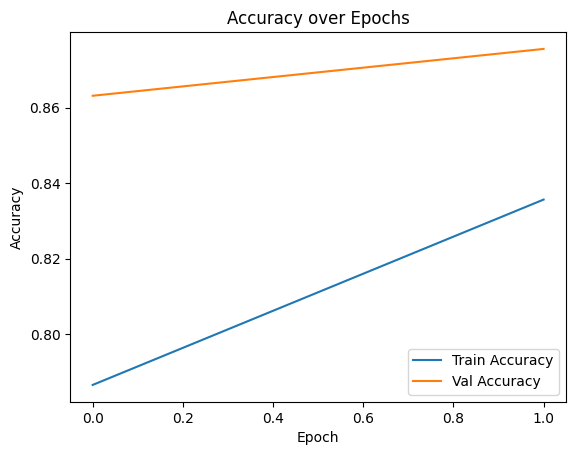

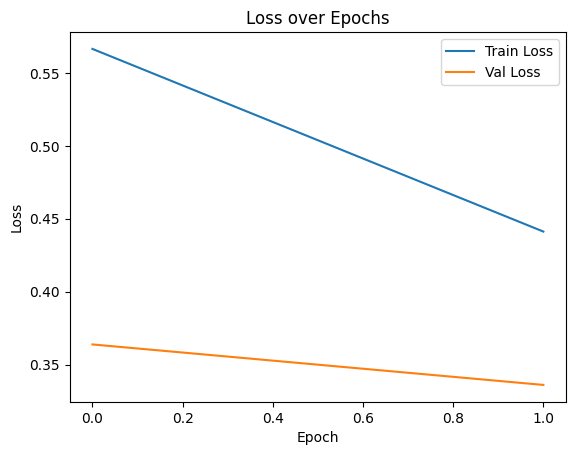

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set image size and paths
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 2
train_dir = '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_train/seg_train'
test_dir = '/root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2/seg_test/seg_test'
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea']

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=class_names,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    classes=class_names,
    class_mode='categorical'
)

# looad base VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the base model

# add custom layers
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# compile the model
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

# Plotting accuracy and loss over the course of training

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
# printing accuracy and loss
ModelLoss, ModelAccuracy = model.evaluate(test_generator)
print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

79/79 ━━━━━━━━━━━━━━━━━━━━ 665s 8s/step - accuracy: 0.8770 - loss: 0.3533
Test Loss is 0.33604294061660767
Test Accuracy is 0.8755502104759216


In [9]:
# Saving the model
model.save("vgg16_model_2epoch.h5", include_optimizer = True)

In [12]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predictions
Y_predictions = model.predict(test_generator)
y_pred = np.argmax(Y_predictions, axis=1)

# True labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_labels, y_pred, target_names=class_labels))

79/79 ━━━━━━━━━━━━━━━━━━━━ 673s 8s/step
              precision    recall  f1-score   support

   buildings       0.17      0.18      0.18       437
      forest       0.19      0.20      0.20       474
     glacier       0.23      0.22      0.22       553
    mountain       0.24      0.21      0.23       525
         sea       0.22      0.24      0.23       510

    accuracy                           0.21      2499
   macro avg       0.21      0.21      0.21      2499
weighted avg       0.21      0.21      0.21      2499



<Axes: >

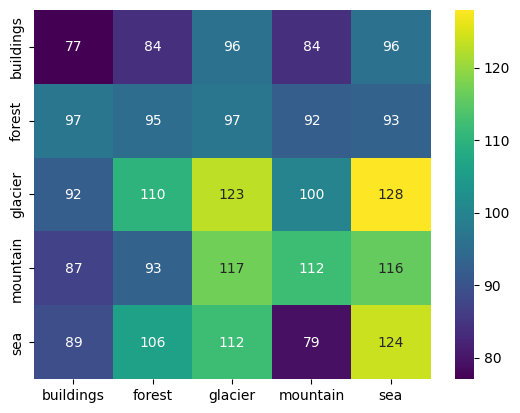

In [13]:
# Prediction heat map
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
sns.heatmap(confusion_matrix(true_labels, y_pred),
            annot=True,
            fmt='.3g',
            xticklabels = class_labels,
            yticklabels = class_labels,
            cmap='viridis')